In [1]:
#importing required libraries
from keras.datasets import cifar100
from tensorflow import keras
import keras, os
import numpy as np
import tensorflow as tf
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, AvgPool2D
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input, Softmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
from keras import regularizers

In [2]:
x_shape = keras.Input((32, 32, 3))
num_classes = 100
train = True

In [3]:
# Downlaoding the cifar100 data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169009152/169001437 [==============================] - 6s 0us/step


In [4]:
def normalize(X_train,X_test):
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = normalize(x_train, x_test)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
# ResNet 18 model
x_shape = keras.Input((32, 32, 3))

# Stage 1
stage1_conv = keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, padding="SAME", activation = 'relu')(x_shape)
max_pool = keras.layers.MaxPool2D(padding="SAME")(stage1_conv)

# Stage 2
stage2_conv1 = Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(max_pool)
stage2_conv2 = Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage2_conv1)
stage2_skip1 = keras.layers.add([max_pool, stage2_conv2])

stage2_conv3 = Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage2_conv2)
stage2_conv4 = Conv2D(filters=64, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage2_conv3)
stage2_resize = Conv2D(filters=64, kernel_size=1, strides=2, padding="SAME")(stage2_skip1)
stage2_skip2 = keras.layers.add([stage2_resize, stage2_conv4])

# Stage 3
stage3_conv1 = Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage2_skip2)
stage3_conv2 = Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage3_conv1)
stage3_resize1 = Conv2D(filters=128, kernel_size=1, strides=1, padding="SAME")(stage2_skip2)
stage3_skip1 = keras.layers.add([stage3_resize1, stage3_conv2])

# stage3_conv3 = Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage3_skip1)
# stage3_conv4 = Conv2D(filters=128, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage3_conv3)
# stage3_resize2 = Conv2D(filters=128, kernel_size=1, strides=2, padding="SAME")(stage3_skip1)
# stage3_skip2 = keras.layers.add([stage3_resize2, stage3_conv4])

# Stage 4
stage4_conv1 = Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage3_skip1)
stage4_conv2 = Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage4_conv1)
stage4_resize1 = Conv2D(filters=256, kernel_size=1, strides=1, padding="SAME")(stage3_skip1)
stage4_skip1 = keras.layers.add([stage4_resize1, stage4_conv2])

# stage4_conv3 = Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage4_skip1)
# stage4_conv4 = Conv2D(filters=256, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage4_conv3)
# stage4_resize2 = Conv2D(filters=256, kernel_size=1, strides=2, padding="SAME")(stage4_skip1)
# stage4_skip2 = keras.layers.add([stage4_resize2, stage4_conv4])

# Stage 5
stage5_conv1 = Conv2D(filters=512, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage4_skip1)
stage5_conv2 = Conv2D(filters=512, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage5_conv1)
stage5_resize1 = Conv2D(filters=512, kernel_size=1, strides=1, padding="SAME")(stage4_skip1)
stage5_skip1 = keras.layers.add([stage5_resize1, stage5_conv2])

# stage5_conv3 = Conv2D(filters=512, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage5_skip1)
# stage5_conv4 = Conv2D(filters=512, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage5_conv3)
# stage5_resize2 = Conv2D(filters=512, kernel_size=1, strides=1, padding="SAME", activation = 'relu')(stage5_skip1)
# stage5_skip2 = keras.layers.add([stage5_resize2, stage5_conv4])

# Average Pooling
avg_pooling = AvgPool2D(strides=2)(stage5_skip1)

flat = Flatten()(avg_pooling)
dense10 = Dense(100)(flat)
softmax = Softmax()(dense10)

# Create Model
model = keras.Model(inputs=x_shape, outputs=softmax)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 16, 16, 64)   36928       max_pooling2d_2[0][0]            
_______________________________________________________________________________________

In [9]:
# Model compilation
from keras.metrics import Precision, Recall
model.compile(optimizer=keras.optimizers.Adam(lr=.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall'])

In [10]:
batch_size = 128
checkpoint = ModelCheckpoint("ResNet18_Adam_NoRegularization", monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=True, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40, verbose=2, mode='auto')


# Data Augmentation
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = False,
                             rotation_range = 10,
                             fill_mode = 'nearest',)

# Train model
hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    validation_data=(x_test, y_test),callbacks=[checkpoint, early],verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.22140, saving model to ResNet18_Adam_NoRegularization
390/390 - 24s - loss: 3.7027 - accuracy: 0.1453 - precision: 0.6007 - recall: 0.0173 - val_loss: 3.2484 - val_accuracy: 0.2214 - val_precision: 0.6553 - val_recall: 0.0498
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.22140 to 0.30380, saving model to ResNet18_Adam_NoRegularization
390/390 - 23s - loss: 3.0696 - accuracy: 0.2543 - precision: 0.6710 - recall: 0.0674 - val_loss: 2.8286 - val_accuracy: 0.3038 - val_precision: 0.6863 - val_recall: 0.1107
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.30380 to 0.34190, saving model to ResNet18_Adam_NoRegularization
390/390 - 23s - loss: 2.7740 - accuracy: 0.3093 - precision: 0.7083 - recall: 0.1127 - val_loss: 2.6474 - val_accuracy: 0.3419 - val_precision: 0.7147 - val_recall: 0.1548
Epoch 4/100

Epoch 00004: val_accuracy improved fro

In [15]:
# Save model
model.save_weights('ResNet18_Adam_NoRegularization.h5') 

In [12]:
# Loading saved weights
model.load_weights(filepath = 'ResNet18_Adam_NoRegularization')
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Precison: %.2f%%" % (scores[2]*100))
print("Recall: %.2f%%" % (scores[3]*100))

Accuracy: 55.06%
Precison: 59.21%
Recall: 53.30%


Text(0.5, 1.0, 'recall')

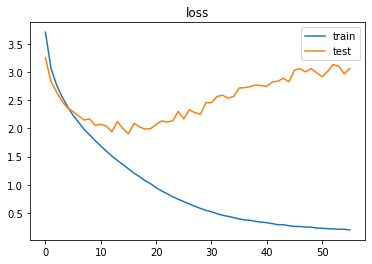

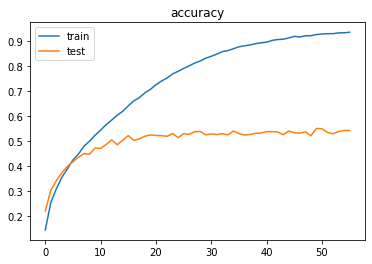

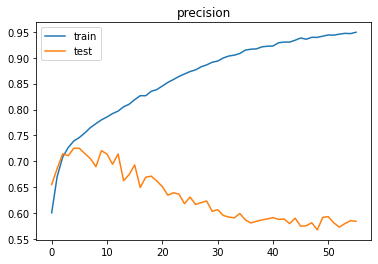

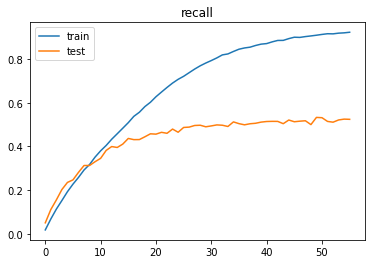

In [13]:
# Plotting accuracy, loss, precision and recall
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.figure()
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.legend(['train','test'])
plt.title('precision')
plt.figure()
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.legend(['train','test'])
plt.title('recall')

In [14]:
# Printing the saved weights in numpy arrays
for layer in model.layers: 
  print(layer.get_weights())

[]
[array([[[[ 4.71106777e-03, -8.26638006e-03,  1.69078037e-02, ...,
           7.25696422e-03, -1.28715031e-03,  8.11794586e-03],
         [-4.24305871e-02,  6.85275486e-03, -6.05414994e-03, ...,
           1.41691753e-05, -4.12809104e-02, -1.53240860e-02],
         [ 6.71589933e-03, -2.46139001e-02,  1.83517076e-02, ...,
          -8.85400269e-03, -3.33977155e-02,  1.82688311e-02]],

        [[ 5.36428615e-02,  1.21179093e-02,  6.71340479e-03, ...,
           3.65653895e-02,  1.27471285e-02, -5.57189621e-02],
         [ 8.41436163e-03,  1.81651283e-02, -2.76211407e-02, ...,
           3.05619221e-02, -5.51207587e-02,  4.64530708e-03],
         [-1.37156527e-02,  4.40867804e-02,  3.95785496e-02, ...,
           3.12610567e-02, -6.03275411e-02,  3.92151438e-02]],

        [[-9.31364205e-03,  2.70634294e-02, -3.27678397e-02, ...,
           2.88101640e-02,  1.22439461e-02, -5.18504940e-02],
         [ 4.09124047e-03,  2.84440927e-02,  2.00739410e-02, ...,
           4.55438420e-02, -4.

REFRENCES

1. https://cv-tricks.com/keras/understand-implement-resnets/
2. https://github.com/kklosowski/CIFAR10-with-Keras/blob/master/Cifar10Keras.ipynb
3. https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/